# Notebook to test if preprocessing will improve hg4 signal

Francesca and I lowered the camera gain for the muscle imaging setup, which seemed to make the image quality better. However, it seems like signals are being extracted for small muscles more reliably from the high gain, grainier images. Seems like we should be able to recover this with low gain images though, unless pixels are saturated?


## Imports

In [11]:
import os
import sys
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pickle as cPickle

In [12]:
# hacky way to get my gcamp extraction
from planotaxis_scratch_base_fns import get_local_folder
current_dir = get_local_folder()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

sys.path.append(parent_dir)
from extract_muscle_signals import extract_gcamp_signals

## Some params

In [13]:
# should we draw muscle outlines?
outline_flag = True

# define a list of muscle names
muscle_names = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3',
                'hg1', 'hg2', 'hg3', 'hg4']

## Helper functions

In [14]:
def sig_correlations(sig,imgs):
    """ 
    calculate some summary images including the correlation image (from Thad's code)
    """
    # mean image
    mean_img = np.mean(imgs,axis=0)
    # mean subtracted
    zeroed_img = imgs - mean_img
    # max
    max_img = np.max(imgs,axis = 0)
    # norm of mean subtracted
    norm_img = np.linalg.norm(zeroed_img,axis = 0)
    # mean subtracted signal
    norm_sig = np.linalg.norm(sig-np.mean(sig))
    # correlation between 1D signal and image stack pixels
    dot_img = np.sum(zeroed_img*(sig[:,np.newaxis,np.newaxis]-np.mean(sig)),axis = 0)
    # dot_img = np.sum(zeroed_img*np.broadcast_to(sig-np.mean(sig), zeroed_img.T.shape).T,axis = 0)
    corr_img = dot_img/(norm_img*norm_sig)
    
    return {'mean_img':mean_img,
        'max_img':max_img,
        'norm_img':norm_img,
        'dot_img':dot_img,
        'corr_img':corr_img}


In [15]:
def draw_muscle_outlines(ax, outline_dict, line_width=0.75,  line_style='-', 
                         line_color='k', outline_alpha=1, muscle_names=muscle_names ):
    """
    Convenience function to create plot objects for muscle outlines on input axis
    
    outline_color = 'y'  #'r' 
    outline_lw = 0.75  # linewidth
    outline_alpha = 0.5
    outline_ls = ':'
    
    muscle_names = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3',
                'hg1', 'hg2', 'hg3', 'hg4']
    """
    # initialize storage
    outline_plot_dict = dict()
    
    # need to add a condition for intializing plots
    for name in muscle_names:
        p, = ax.plot(outline_dict[name][0,:],outline_dict[name][1,:], ls=line_style, 
                     lw=line_width, color=line_color, label=name, alpha=outline_alpha)
        outline_plot_dict[name] = p
    
    # return our dictionary of plot objects
    return outline_plot_dict


In [16]:
def construct_rframe_dict(e1, e2):
    """Make a dictionary containing refrence frame info"""
    frame = dict()

    frame['e1'] = e1
    frame['e2'] = e2

    frame['a2'] = e1[1] - e2[0]
    frame['a1'] = e2[1] - e2[0]
    frame['p'] = e2[0]

    # also get transformation matrices based on these vectors
    frame['A'] = np.vstack((frame['a1'], frame['a2'])).T
    frame['A_inv'] = np.linalg.inv(frame['A'])

    return frame


In [17]:
def get_rframe_transform(self,other):
    """get transform into self from other frame (muscle imaging reference frames)"""
    A1 = np.hstack((self['A'],self['p'][:,np.newaxis]))
    A2 = np.hstack((other['A'],other['p'][:,np.newaxis]))
    A1 = np.vstack((A1, [0,0,1]))
    A2 = np.vstack((A2, [0,0,1]))

    return np.dot(A1, np.linalg.inv(A2))


## Load data

In [18]:
# which data set would we like to load?
fly_num = 59
data_path = os.path.join('/media/sam/SamData/FlyDB/', 'Fly%04d'%fly_num)

thad_flag = True  # is this data coming from Thad's old drive?

# paths to data
data_fn_prefix = 'ca_camera_left'

rframe_fn = '{}_rframe_fits.cpkl'.format(data_fn_prefix)  # reference frame
img_fn = '{}.hdf5'.format(data_fn_prefix)                 # images
fit_fn = '{}_model_fits.cpkl'.format(data_fn_prefix)      # extracted GCaMP signals

In [19]:
# load images
with h5py.File(os.path.join(data_path, img_fn), 'r') as f:
    imgs = f['cam_imgs'][:]


In [21]:
# load model fits (extracted GCaMP signals)
with open(os.path.join(data_path, fit_fn), 'rb') as f:
    model_fits = cPickle.load(f)
#     model_fits = cPickle.load(f, encoding='latin1')
    

In [22]:
# load reference frame
with open(os.path.join(data_path, rframe_fn), 'rb') as f:
    data_rframe = cPickle.load(f)
#     data_rframe = cPickle.load(f, encoding='latin1')

# reshape the matrices if need be
data_rframe['A'] = np.reshape(data_rframe['A'],(2,2))
data_rframe['A_inv'] = np.reshape(data_rframe['A_inv'],(2,2))


## Take a look at some signals

In [31]:
# going to look in a narrow test range
idx_start = 58000
idx_end = 62000

idx = slice(idx_start, idx_end)

Text(0.5,1,'hg4 and i2')

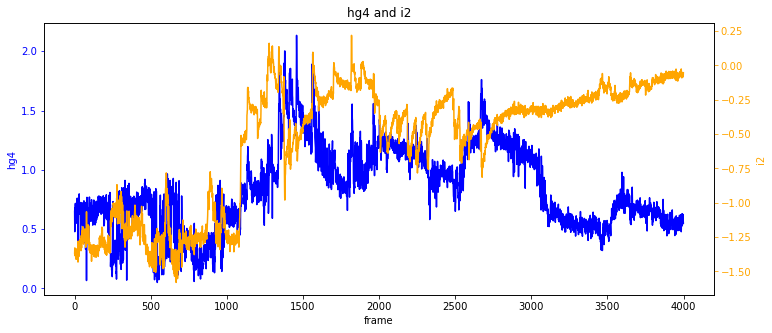

In [32]:
# first let's just plot what we see
fig, ax = plt.subplots(figsize=(12, 5))
twin1 = ax.twinx()

muscle_name1 = 'hg4'
muscle_name2 = 'i2'

# ax.plot(model_fits[muscle_name])
p1, = ax.plot(model_fits[muscle_name1][idx], color='blue')
p2, = twin1.plot(model_fits[muscle_name2][idx], color='orange')

ax.set(xlabel="frame", ylabel=muscle_name1)
twin1.set(ylabel=muscle_name2)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.set_title(muscle_name1 + " and " + muscle_name2)

In [33]:
# what does the correlation image look like in this time range?
muscle_name = 'hg4'  # 'iii3'
muscle_signal = model_fits[muscle_name]

corr_output = sig_correlations(muscle_signal[idx], imgs[idx])


Text(0.5,1,'correlation with hg4')

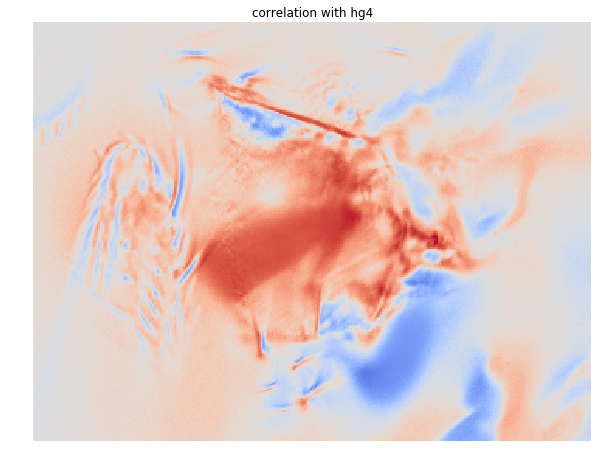

In [34]:
# visualize results
fig, ax = plt.subplots(figsize=(10,10))

# read out image
corr_img = corr_output['corr_img']

# set upper and lower color limit bound
# clim_val = np.percentile(np.abs(corr_img), 98)  # clim_val = np.max(np.abs(corr_img))
clim_val = np.max(np.abs(corr_img))

ax.imshow(corr_img, cmap='coolwarm', vmin=-clim_val, vmax=clim_val)

# turn off axis ticks
ax.axis('off')
ax.set_title('correlation with {}'.format(muscle_name))

## Try some simple bg subtraction

In [47]:
# first attempt: what about just subtracting off the lowest percentile pixels?
ptile_img = np.percentile(imgs[idx], 50, axis=0)


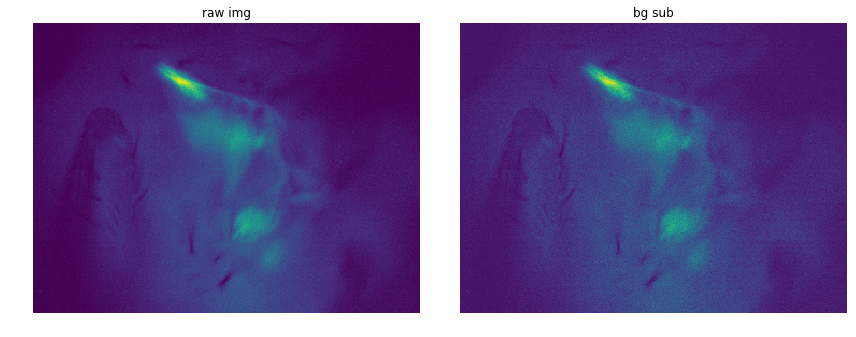

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ind = 4000
ax1.imshow(imgs[idx_start + ind], interpolation='none')
ax1.axis('off')
ax1.set_title('raw img')

ax2.imshow(imgs[idx_start + ind] - 0.4*ptile_img, interpolation='none')
ax2.axis('off')
ax2.set_title('bg sub')

plt.tight_layout()

In [87]:
# morphological reconstruction?
from skimage.morphology import reconstruction
from skimage.filters import gaussian
from skimage.util import img_as_float, img_as_ubyte

image = imgs[idx_start+ind]
image = gaussian(img_as_float(image))

h = 0.3
seed = image - h
mask = image
dilated = reconstruction(seed, mask, method='dilation')
hdome = image - dilated

Text(0.5,1,'image - dilated')

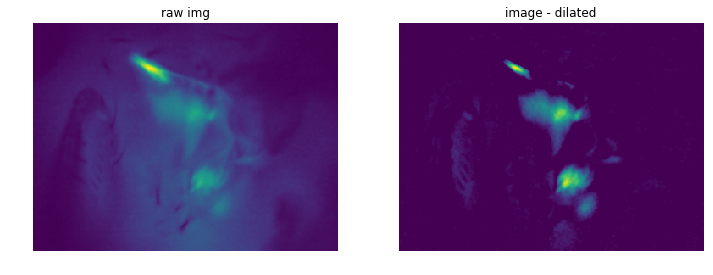

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(image, interpolation='none')
ax1.axis('off')
ax1.set_title('raw img')

ax2.imshow(img_as_ubyte(hdome), interpolation='none')
ax2.axis('off')
ax2.set_title('image - dilated')


In [75]:
print(np.max(img_as_ubyte(hdome)))

153


In [89]:
# should we try to do reconstruction and see what this does to signal?
imgs_recon = list()

h = 0.3

for ith in range(idx_start, idx_end):
    image = imgs[ith]
    image = gaussian(img_as_float(image))
    
    seed = image - h
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    hdome = image - dilated
    
    imgs_recon.append(img_as_ubyte(hdome))
    
    # print(ith)
    
imgs_recon = np.asarray(imgs_recon)

In [90]:
# do reconstruction on processed images
model_fits_recon = extract_gcamp_signals(imgs_recon, data_rframe)

4000
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 97200)
Done with chunk
(100, 972

In [92]:
# # wait, first, does this function give the right results?
# model_fits_test = extract_gcamp_signals(imgs[idx], data_rframe)

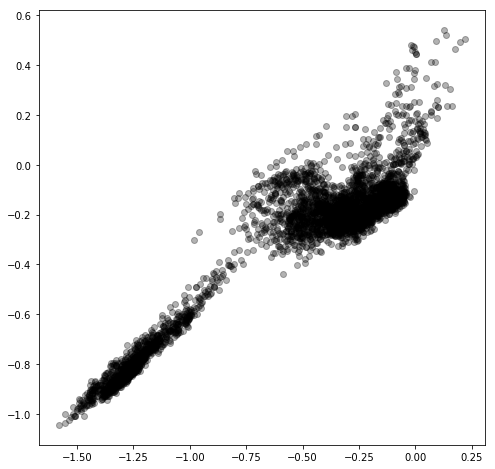

In [93]:
fig, ax = plt.subplots(figsize=(8,8))

muscle_name = 'i2'
ax.plot(model_fits[muscle_name][idx], model_fits_recon[muscle_name], 'ko', alpha=0.3)
# ax.plot(model_fits_recon[muscle_name])

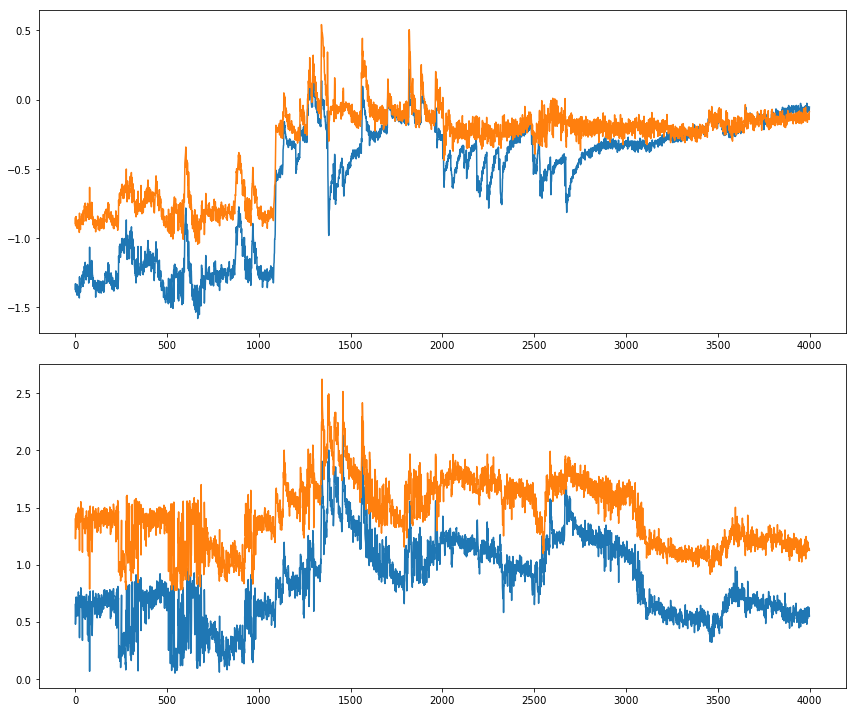

In [97]:
muscle_names = ['i2', 'hg4', 'iii3']

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))

for jth, muscle_name in enumerate(muscle_names):
ax1.plot(model_fits[muscle_name])
ax1.plot(model_fits_recon[muscle_name1])

ax2.plot(model_fits[muscle_name2][idx])
ax2.plot(model_fits_recon[muscle_name2])

fig.tight_layout()

In [111]:
# how does this affect correlation images
muscle_name = 'hg4'  # 'iii3'
muscle_signal = model_fits[muscle_name]

corr_output = sig_correlations(muscle_signal[idx], imgs[idx])
corr_output_recon = sig_correlations(model_fits_recon[muscle_name], imgs[idx])
# corr_output = sig_correlations(muscle_signal[idx], imgs_recon)
# corr_output_recon = sig_correlations(model_fits_recon[muscle_name], imgs_recon)


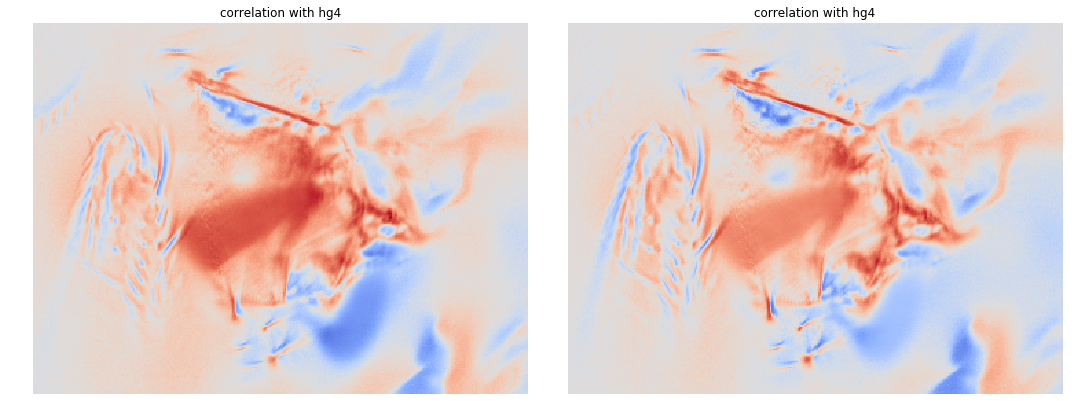

In [112]:
# visualize results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

# read out images
corr_img = corr_output['corr_img']
corr_img_recon = corr_output_recon['corr_img']

# set upper and lower color limit bound
# clim_val = np.percentile(np.abs(corr_img), 98)  # clim_val = np.max(np.abs(corr_img))
clim_val = np.max(np.abs(corr_img))

ax1.imshow(corr_img, cmap='coolwarm', vmin=-clim_val, vmax=clim_val)
ax1.axis('off') # turn off axis ticks
ax1.set_title('correlation with {}'.format(muscle_name))

ax2.imshow(corr_img_recon, cmap='coolwarm', vmin=-clim_val, vmax=clim_val)
ax2.axis('off') # turn off axis ticks
ax2.set_title('correlation with {}'.format(muscle_name))

fig.tight_layout()